In this project, we will train a GNN to perform link prediction on a heterogenous graph from the Spotify Million Playlists dataset.

# Import libraries

In [16]:
import sys  
sys.path.insert(0, '/home/yon/jupyter-server/mlg/src/')

import loader
import config
import model as M
import preprocessing
from pprint import pprint
import torch
import random
import torch_geometric
import numpy as np
import time
import matplotlib.pyplot as plt
import torch_geometric.transforms as T

# Model

In [17]:
from model import *

# Test Run

In [18]:
ghetero = loader.get_ghetero(False, config)
data_train, data_val, data_test = loader.get_datasets(False, config)

Loading ghetero from pickle ...
Loading datasets from pickle ...


Train100%|██████████| 2000/2000 [02:12<00:00, 15.10epoch/s, Train Loss: 0.1777, Train Accuracy 0.7358, Valid Loss 0.2252, Valid Accuracy 0.6263]


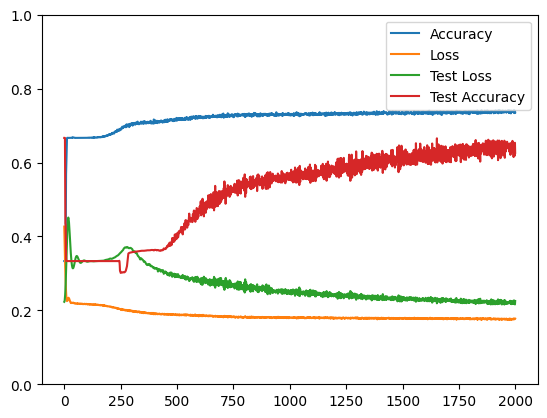

In [19]:
# create training mask for playlist nodes
train_mask = torch.zeros(ghetero["playlist"].x.shape[0], dtype=torch.bool)
train_mask[torch.randperm(train_mask.shape[0])[:int(train_mask.shape[0]*0.8)]] = True

ghetero["playlist"].train_mask = train_mask

ghetero["playlist"].y = torch.LongTensor([1]*ghetero["playlist"].x.shape[0]).to(device)

model = HeteroModel(64, ghetero.x_dict, ghetero.metadata()).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00001)
edge_label_index = data_train["track", "contains", "playlist"].edge_label_index
edge_label = data_train["track", "contains", "playlist"].edge_label

train_loader = torch_geometric.loader.LinkNeighborLoader(
    data=data_train,
    num_neighbors=[-1],
    neg_sampling_ratio=0.5,
    edge_label_index=(("track", "contains", "playlist"), edge_label_index),
    edge_label=edge_label,
    batch_size=20000,
    shuffle=True,
    transform=T.ToDevice(device)
)

import tqdm
epoch = 2000
render_graph = True

losses = []
accuracies = []
test_losses = []
test_accuracies = []

epoch_iter = tqdm.tqdm(range(epoch), unit='epoch', desc='Training', bar_format='{desc:<5.5}{percentage:3.0f}%|{bar:10}{r_bar}')
for i in epoch_iter:
    loss, accuracy = train(model, train_loader, optimizer)
    losses.append(loss)
    accuracies.append(accuracy)
    test_loss, test_acc = test(model, data_val)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    epoch_iter.set_postfix_str(f"Train Loss: {loss:.4f}, Train Accuracy {accuracy:.4f}, Valid Loss {test_loss:.4f}, Valid Accuracy {test_acc:.4f}")

plt.clf()
# add labels
plt.plot(np.arange(len(accuracies)), accuracies, label='Accuracy')
plt.plot(np.arange(len(losses)), losses, label='Loss')
plt.plot(np.arange(len(test_losses)), test_losses, label='Test Loss')
plt.plot(np.arange(len(test_accuracies)), test_accuracies, label='Test Accuracy')
# add legend

#start plot at 0
plt.ylim(0, 1)
plt.legend()
plt.show()